# Using machine learning XGboost classifier to look for different pattern between Ketamin and Midazolam groups
- Running on the Beta of trauma1_0 instead of contrast between trauma and sad (more similar to MVPA)

In [47]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## No apperant contribution to before/after treatment in general. 
- Lets look at group differences in ROIs $\rightarrow$
    * Amygdala
    * vmPFC
    * Hippocampus
    * Striatum
- We compare pattern of ROI activation in the trauma > relax contrast on the 2nd day

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


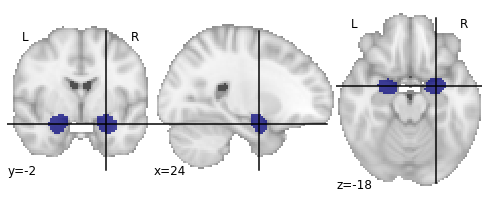

In [72]:
## Amygdala as mask
mask_file = '/media/Data/work/KPE_ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=21", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)


masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                smoothing_fwhm=6, verbose=5).fit()

In [73]:
# compare between groups
import pandas as pd
medication_cond = pd.read_csv('/home/or/kpe_task_analysis/task_based_analysis/kpe_sub_condition.csv')
medication_cond

condition_label = np.array(medication_cond.med_cond)
condition_label = list(map(int, condition_label))
condition_label

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]

In [74]:
# function to find ev number (lookin in run.fsf file)
def findEV(txtFile, condition):
    # takes the txtFile and the specific condition
    with open(txtFile) as f:
        datafile = f.readlines()
        lines = []
        for line in datafile:
            if condition in line:
                # found = True # Not necessary
                #print(line)
                lines.append(line)

    return lines[0].split('evtitle')[1].split(')')[0]

def getBetas(beta_list, condition, ses):
    betaTemplate = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses{ses}_Nosmooth/modelfit_ses_{ses}/_subject_id_{subject_id}/modelestimate/mapflow/_modelestimate0/results/pe{betaNum}.nii.gz'
    beta_files = []
    for beta in beta_list:
        # get subject number
        sub = beta.split('id_')[1].split('/')[0]
        # get beta number
        number = findEV(beta, condition)
        # find beta file
        betaFile = betaTemplate.format(ses=ses, subject_id = sub, betaNum = number)
        # add it to list
        beta_files.append(betaFile)
    beta_files.sort()
    return beta_files

In [75]:
# get run files - for specific session
ses= '2'
beta_list = glob.glob('/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses%s_Nosmooth/modelfit_ses_%s/_subject_id_*/level1design/run0.fsf' %(ses,ses))
beta_list


['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1322/level1design/run0.fsf',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1387/level1design/run0.fsf',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1339/level1design/run0.fsf',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1464/level1design/run0.fsf',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1315/level1design/run0.fsf',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1223/level1design/run0.fsf',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_N

In [76]:
# get condition list
events_file = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/condition_files/withNumbers/sub-1464_ses-1_30sec_window.csv'
cond = pd.read_csv(events_file, sep='\t')
cond_list = np.unique(cond.trial_type_30)
cond_list

array(['relax1_0', 'relax1_1', 'relax1_2', 'relax1_3', 'relax2_0',
       'relax2_1', 'relax2_2', 'relax2_3', 'relax3_0', 'relax3_1',
       'relax3_2', 'relax3_3', 'sad1_0', 'sad1_1', 'sad1_2', 'sad1_3',
       'sad2_0', 'sad2_1', 'sad2_2', 'sad2_3', 'sad3_0', 'sad3_1',
       'sad3_2', 'sad3_3', 'trauma1_0', 'trauma1_1', 'trauma1_2',
       'trauma1_3', 'trauma2_0', 'trauma2_1', 'trauma2_2', 'trauma2_3',
       'trauma3_0', 'trauma3_1', 'trauma3_2', 'trauma3_3'], dtype=object)

In [77]:
beta_files = getBetas(beta_list, 'trauma1_0', ses='2')
print(beta_files)
allGroups = []
for func in beta_files:
    print(f'Running {func}')
    beta = masker.transform(func)
    allGroups.append(beta)

allArr = np.array(allGroups)
allArr_reshape= np.array(allArr).reshape(allArr.shape[0], allArr.shape[2])
allArr_reshape.shape

['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_008/modelestimate/mapflow/_modelestimate0/results/pe31.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1223/modelestimate/mapflow/_modelestimate0/results/pe31.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1253/modelestimate/mapflow/_modelestimate0/results/pe31.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1263/modelestimate/mapflow/_modelestimate0/results/pe31.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1293/modelestimate/mapflow/_modelestimate0/results/pe31.nii.gz', '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_resul

[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1339/modelestimate/mapflow/_modelestimate0/results/pe31.nii.gz
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses2_Nosmooth/modelfit_ses_2/_subject_id_1343/modelesti

[NiftiMasker.transform_single_imgs] Cleaning extracted signals


(21, 846)

In [78]:
X = allArr_reshape

In [79]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
model = XGBClassifier(n_jobs=5, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=10, shuffle=True) # running for each subject


In [80]:
scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "accuracy",
                            n_jobs=1, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )

In [81]:
scores

array([0.66666667, 0.        , 0.        , 1.        , 0.5       ,
       0.5       , 0.        , 1.        , 0.        , 1.        ])

## Use shuffle split to randomize and run the XGboost N times
- This will create a distribution of estimation level 
- We can then better estimate how really its more accurate than chance


In [82]:
n_iter = 100
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "accuracy",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

### Plotting area under ROC curve ditribution and printing average and standard deviation of the distribution

Area under curve: 0.50 (+/- 0.10)
90% CI is [0.41666667 0.58333333]


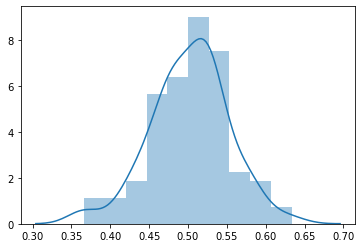

In [83]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'90% CI is {np.quantile(rand_score, [0.05, 0.95])}')
sns.distplot(rand_score)

In [84]:
## use sklearn permutation test
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    model, X, condition_label, scoring="roc_auc", cv=cv, n_permutations=1000, n_jobs=8, verbose=5)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   18.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   43.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:  4.3min


Classification score 0.3 (pvalue : 0.8291708291708292)


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  4.9min finished


In [231]:
X.shape

(21, 3846)

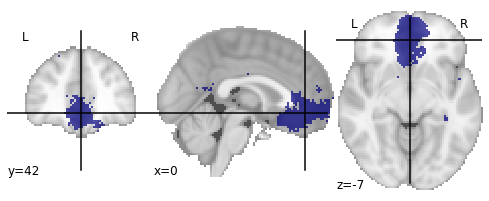

In [219]:
mask_file = '/media/Data/work/RCF_or/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=4", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, verbose=5)

## Lets look at the hippocampus

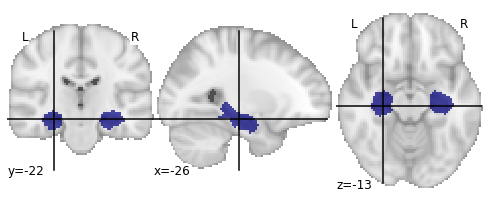

In [210]:
mask_file = '/media/Data/work/KPE_ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=11", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, verbose=5)

## Striatum

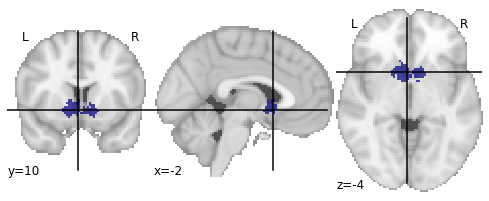

In [204]:
mask_file = '/media/Data/work/KPE_ROI/binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz'
mask_file = nilearn.image.math_img("a>=0.001", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, verbose=5)

# An unrelated region (Primary motor cortex?) V1?